In [1]:
import numpy as np
import tensorflow as tf
import os # Directory navigation
import random
#import wave # Read wav file
import librosa # More audio processing
import seaborn as sns
#import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
#!pip install sklearn
from sklearn.preprocessing import LabelEncoder

C:\Users\I27645\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\I27645\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Constants
DATA_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands/'
LOADING_PATH = 'data/mini_speech_commands'
NOISE_PATH = 'background/_background_noise_/'
SAMPLE_RATE = 16000  # Standard sample rate
DURATION = 1.0  # Duration of each clip in seconds
N_MFCC = 40  # Number of MFCC features
N_MELS = 128  # Number of mel bands
HOP_LENGTH = 512  # Hop length
N_FFT = 2048  # FFT window size

#seeds
# Set seed
seed = 36
tf.random.set_seed(seed)
np.random.seed(seed)

# 1. Dataset Load & Prep:
## Define Helper functions to load files, add noise, and extract Audio Features
### Add noise

In [3]:
# Get random sample from audio
def sample_noise(noise_audio, target_length=1600):
    """
    Samples a random segment of noise to match the target audio length.
    """
    noise_length = len(noise_audio)
    if target_length > noise_length:
        raise ValueError("Noise file is too short for sampling.")
    
    start_idx = random.randint(0, noise_length - target_length)
    return noise_audio[start_idx:start_idx + target_length]

# Add Background Noise
def add_background_noise(audio, noise_path=NOISE_PATH, noise_level=0.2):
    #noise_files = [os.path.join(noise_path, f) for f in os.listdir(noise_path) if f.endswith('.wav')]
    #noise_file = np.random.choice(noise_files)
    noise_audio, sr = librosa.load('background\_background_noise_\exercise_bike.wav', sr=SAMPLE_RATE)
    #random sample
    #noise_audio = sample_noise(noise_audio)
    noise_audio = librosa.util.fix_length(noise_audio, size=len(audio))
    return audio + noise_level * noise_audio



### Extract Features

In [4]:
# Helper Function: Extract Audio Features
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, mono=True)
        noisey_audio = add_background_noise(audio)
        mel_spec = librosa.feature.melspectrogram(y=noisey_audio, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), n_mfcc=N_MFCC)
        #chroma = librosa.feature.chroma_stft(y=noisey_audio, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
        #print('calcs work. tryinf concat2')
        # Combine features: mel-spectrogram mean, MFCC mean, and chroma mean
        return [[
            mel_spec, 
            mfccs.T
            #chroma.flatten()
        ]]
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

### Load Data while Extracting Features and adding noise

In [6]:
# Load Data and Extract Features
def load_data(DATA_PATH):
    features = []
    labels = []
    for label in os.listdir(DATA_PATH):
        class_path = os.path.join(DATA_PATH, label)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(label)

    return features, labels


### Create the dataset

In [7]:
# Load and preprocess the dataset
features, labels = load_data(DATA_PATH)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Save processed features and labels for reuse
#np.save('features.npy', features)
#np.save('labels.npy', labels_encoded)


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

Batch of 64 audio files with 1600hz sample rates?


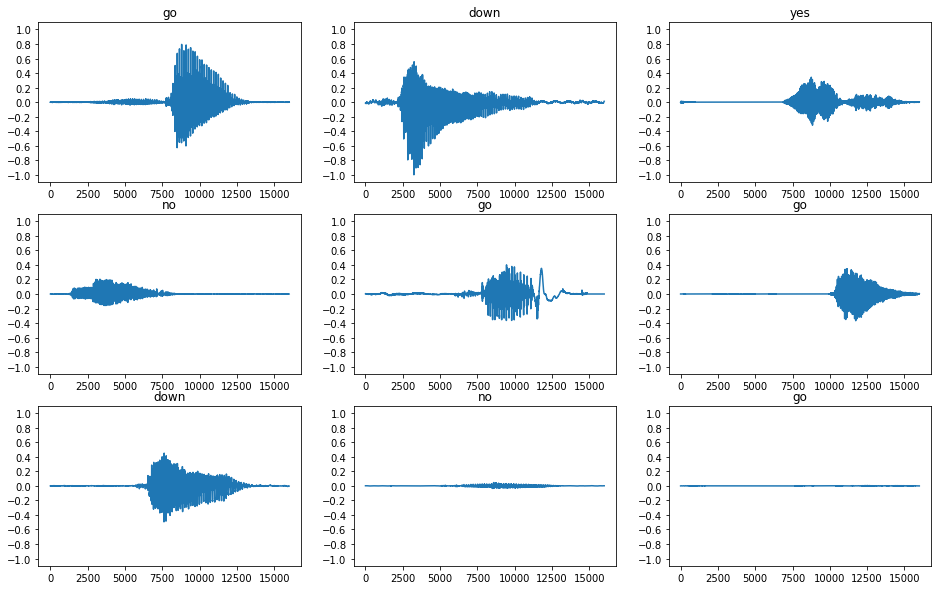

In [16]:
commands[[1,1,3,0]]

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(commands[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## *add test set*
## *remove plots??*
## *do i stack noisy and clean data into one? or only pass 1 set?*

# Add Noise
*use SNR calculation to add noise??*
*leave for now. come back later to randomly add background noise*

In [17]:
# Define the function to add noise
def add_random_noise(audio, label, noise_level=0.0015):
    """
    Add random noise to an audio signal.
    :param audio: TensorFlow tensor representing the audio signal
    :param label: Corresponding label for the audio
    :param noise_level: Standard deviation of the noise
    :return: Augmented audio with noise and the label
    """
    noise = tf.random.normal(shape=tf.shape(audio), mean=0.0, stddev=noise_level, dtype=audio.dtype)
    augmented_audio = audio + noise
    return augmented_audio, label

# Apply the noise augmentation
noise_level = 0.0015  # You can adjust this based on desired noise intensity
augmented_trainset = train_ds.map(lambda x, y: add_random_noise(x, y, noise_level))
augmented_valset = val_ds.map(lambda x, y: add_random_noise(x, y, noise_level))


Audio shape: (64, 16000)
Label: tf.Tensor(
[5 4 6 6 2 4 3 6 0 0 0 6 0 2 4 0 6 4 5 2 1 2 0 4 6 4 7 6 0 7 3 0 1 3 7 7 5
 6 3 3 1 4 0 3 7 1 4 7 0 1 4 1 7 5 0 6 6 0 5 4 6 6 3 1], shape=(64,), dtype=int32)


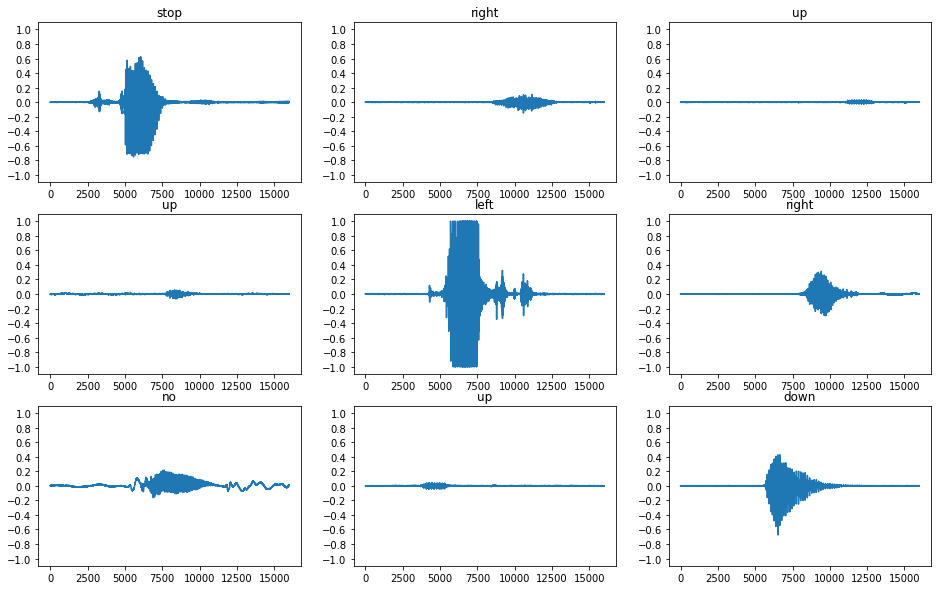

In [18]:
# Preview an example
for audio, label in augmented_trainset.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)

commands[[1,1,3,0]]

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = audio[i]
  plt.plot(audio_signal)
  plt.title(commands[label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Extract Features

## Spectograms

### Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [19]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Explore augmented data

In [20]:
for i in range(3):
  label = commands[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Augmented

In [21]:
# Preview an example
for audio, xlabel in augmented_trainset.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)

for i in range(3):
  label = commands[xlabel[i]]
  waveform = audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Audio shape: (64, 16000)
Label: yes
Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


You can hear the background noise!!

## Plot Spectogram

In [22]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

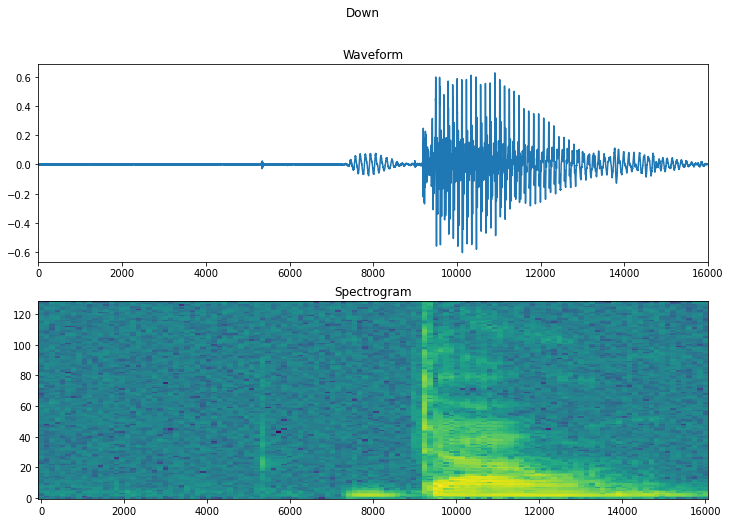

In [23]:
#Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Extract spectogram as a feature into its own dataset

In [24]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
#test_spectrogram_ds = make_spec_ds(test_ds)

Examine a few spectograms

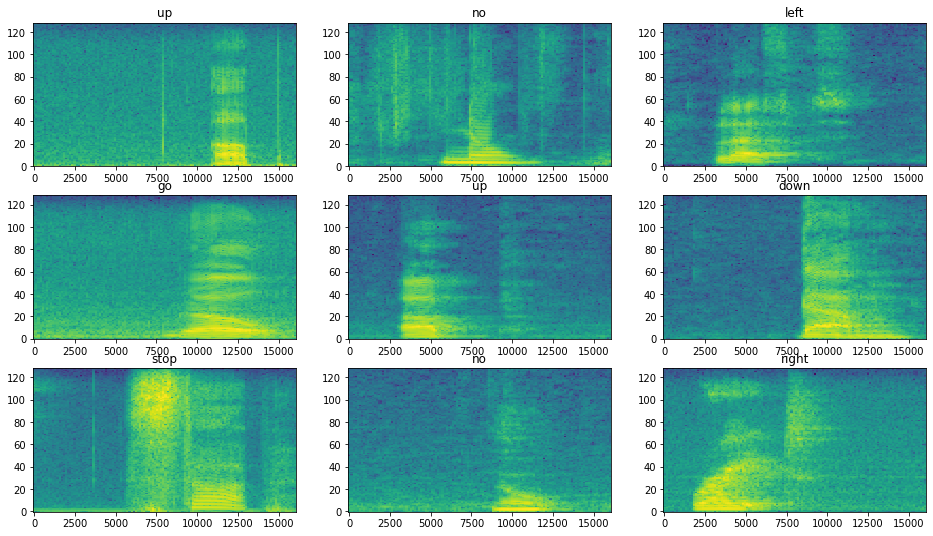

In [26]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## MFCC and melspectgram as a layer
just used MFCC because of real-time computations?

In [ ]:
# STEP 2: Extract MFCC Features
def extract_mfcc(audio, sr, n_mfcc=13): # why 13??
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to make time steps as rows

In [ ]:
# run mfcc calculation
#figure out if we stack and what to input in the model
#spectograms are imaages not sound

# 3. Model Architecture:
Design a CNN-RNN hybrid model. Use CNN layers to capture local time-frequency patterns, RNN layers (LSTM/GRU) for sequential modeling, and attention mechanisms to focus on important audio frames.


Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).